In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import torch.distributions.constraints as constraints

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

# Simple Model

In [5]:
def sprinkler(rain):
    p_sprinkler = 0.01 if rain.item() == 1.0 else 0.2
    return dist.Bernoulli(p_sprinkler)


def grass(rain, sprinkler):
    if rain.item() == 0.0:
        p_grass = 0.9 if sprinkler.item() == 1.0 else 0.01
    else:
        p_grass = 0.99 if sprinkler.item() == 1.0 else 0.95
    return dist.Bernoulli(p_grass)

def model():
    r = pyro.sample('rain', dist.Bernoulli(0.1))
    s = pyro.sample("sprinkler", sprinkler(r))
    g = pyro.sample("grass", grass(r, s), obs=1)

conditioned_grass = pyro.condition(model, data={})
posterior = pyro.infer.Importance(conditioned_grass, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites="rain")

trace = np.array([marginal() for _ in tqdm(range(100000))])

100%|██████████| 100000/100000 [00:02<00:00, 37518.80it/s]


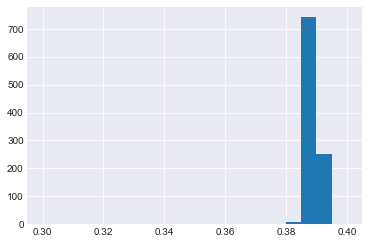

In [6]:
resamples = np.random.choice(trace, size=(1000, len(trace)), replace=True)
_ = plt.hist(resamples.mean(axis=1), bins=np.linspace(0.3, 0.4, 21))

In [7]:
trace.mean()

0.38899

# Parametric Bayesian Model

In [8]:
historical_rain_data = np.array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]).astype(float)
historical_sprk_data = np.array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]).astype(float)
historical_grss_data = np.array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1]).astype(float)

num_days = historical_grss_data.shape[0]
num_days

30

In [9]:
def rain(p):
    return dist.Bernoulli(p)

def sprinkler(rain, p_nr, p_r):
    return dist.Bernoulli(p_r if rain.item() == 1.0 else p_nr)

def grass(rain, sprinkler, p_ns_nr, p_s_nr, p_ns_r, p_s_r):
    if rain.item() == 0.0:
        prob = p_ns_nr if sprinkler.item() == 0.0 else p_s_nr
    else:
        prob = p_ns_r if sprinkler.item() == 0.0 else p_s_r
    return dist.Bernoulli(prob)

def model():
    p = pyro.sample('p', dist.Beta(1.0, 1.0))
    p_nr = pyro.sample('p_nr', dist.Beta(1.0, 1.0))
    p_r = pyro.sample('p_r', dist.Beta(1.0, 1.0))
    p_ns_nr = pyro.sample('p_ns_nr', dist.Beta(1.0, 1.0))
    p_s_nr = pyro.sample('p_s_nr', dist.Beta(1.0, 1.0))
    p_ns_r = pyro.sample('p_ns_r', dist.Beta(1.0, 1.0))
    p_s_r = pyro.sample('p_s_r', dist.Beta(1.0, 1.0))
    
    for i in pyro.irange('day', num_days):
        rain_i = pyro.sample('historic_rain_{}'.format(i), rain(p), obs=historical_rain_data[i])
        sprk_i = pyro.sample('historic_sprk_{}'.format(i), sprinkler(rain_i, p_nr, p_r), obs=historical_sprk_data[i])
        grss_i = pyro.sample('historic_grss_{}'.format(i), grass(rain_i, sprk_i, p_ns_nr, p_s_nr, p_ns_r, p_s_r), obs=historical_grss_data[i])

    today_rain = pyro.sample('today_rain', rain(p))
    today_sprinkler = pyro.sample('today_sprinkler', sprinkler(today_rain, p_nr, p_r))
    today_grass = pyro.sample('today_grass', grass(today_rain, today_sprinkler, p_ns_nr, p_s_nr, p_ns_r, p_s_r), obs=1)

In [10]:
conditioned_grass = pyro.condition(model, data={})
posterior = pyro.infer.Importance(conditioned_grass, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(), sites="today_rain")

trace = np.array([marginal() for _ in tqdm(range(10000))])

100%|██████████| 10000/10000 [00:00<00:00, 36920.78it/s]


In [11]:
trace.mean()

0.0595

# Simple Gaussian Mixture

In [12]:
def model(data):
    softplus = torch.nn.Softplus()
    mix = pyro.sample('mix', dist.Beta(1.0, 1.0))
    mu_1 = pyro.sample('mu_1', dist.Normal(0, 10.0))
    mu_2 = pyro.sample('mu_2', dist.Normal(0, 10.0))
    s_1 = pyro.sample('s_1', dist.LogNormal(0, 1.0))
    s_2 = pyro.sample('s_2', dist.LogNormal(0, 1.0))
    for i in pyro.irange('item', data.shape[0]):
        which = pyro.sample('which_{}'.format(i), dist.Bernoulli(mix))
        if which.item() == 0:
            pyro.sample("x_{}".format(i), dist.Normal(mu_1, s_1), obs=data[i])
        else:
            pyro.sample("x_{}".format(i), dist.Normal(mu_2, s_2), obs=data[i])

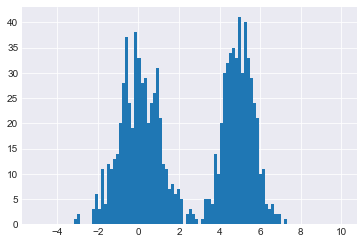

In [22]:
N = 1000
X_1 = np.random.normal(0, 1, size=N)
X_2 = np.random.normal(5.0, 0.7, size=N)
which = np.random.randint(0, 2, size=N)
X = (which * X_1 + (1 - which) * X_2)
data = torch.tensor(X).type(torch.Tensor)

_ = plt.hist(X, bins=np.linspace(-5, 10, 101))

In [24]:
posterior = pyro.infer.Importance(model, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(data), sites="mix")

KeyboardInterrupt: 

In [ ]:
trace = np.array([marginal() for _ in tqdm(range(10000))])

# Regressão Linear Bayesiana

In [ ]:
N = 20  # size of toy data

def build_linear_dataset(N, p=1, noise_std=0.01):
    X = np.random.rand(N, p)
    w = 7 * np.ones(p)
    y = np.matmul(X, w) + np.repeat(1, N) + np.random.normal(0, noise_std, size=N)
    y = y.reshape(N, 1)
    X, y = torch.tensor(X).type(torch.Tensor), torch.tensor(y).type(torch.Tensor)
    data = torch.cat((X, y), 1)
    assert data.shape == (N, p + 1)
    return data

data = build_linear_dataset(N, noise_std=0.75)

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)

    def forward(self, x):
        return self.linear(x)

regression_model = RegressionModel(1)

### Discriminative Learning

In [ ]:
loss_fn = torch.nn.MSELoss(size_average=False)
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 2000

x_data = data[:, :-1]
y_data = data[:, -1]
for j in range(num_iterations):
    y_pred = regression_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (j + 1) % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

print("Learned parameters:")
for name, param in regression_model.named_parameters():
    print("%s: %.3f" % (name, param.data.numpy()))

In [ ]:
def model(data):
    loc, scale = torch.zeros(1, 1), 10 * torch.ones(1, 1)
    bias_loc, bias_scale = torch.zeros(1), 10 * torch.ones(1)
    
    w_prior = dist.Normal(loc, scale).independent(1)
    b_prior = dist.Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    lifted_reg_model = lifted_module()
    
    with pyro.iarange("map", N):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs", dist.Normal(prediction_mean, 0.1 * torch.ones(data.size(0))), obs=y_data)

        
softplus = torch.nn.Softplus()

def guide(data):

    w_loc = torch.randn(1, 1)
    w_log_sig = torch.tensor(1.0 * torch.ones(1, 1) + 0.05 * torch.randn(1, 1))
    b_loc = torch.randn(1)
    b_log_sig = torch.tensor(1.0 * torch.ones(1) + 0.05 * torch.randn(1))

    mw_param = pyro.param("guide_mean_weight", w_loc)
    sw_param = softplus(pyro.param("guide_log_scale_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_loc)
    sb_param = softplus(pyro.param("guide_log_scale_bias", b_log_sig))

    w_dist = dist.Normal(mw_param, sw_param).independent(1)
    b_dist = dist.Normal(mb_param, sb_param).independent(1)
    dists = {'linear.weight': w_dist, 'linear.bias': b_dist}
    lifted_module = pyro.random_module("module", regression_model, dists)
    return lifted_module()


In [ ]:
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(N)))


In [ ]:
for name in pyro.get_param_store().get_all_param_names():
    print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))

In [ ]:
softplus(torch.tensor(-2.516)).item()